# Preselections and out-of-core computations with hax

Jelle, 7 October 2016

In [1]:
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
from tqdm import tqdm
import dask

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from pax.configuration import load_configuration
pax_config = load_configuration('XENON1T')

import hax
from hax import cuts
# Load minitrees from several analysts kind enough to share their home directory
# If you think this is getting crazy, I agree... the solution is a common minitree folder
# with pre-made basics minitrees. But that would require someone maintaining it.
hax.init(minitree_paths=['.', 
                         '/home/aalbers/minitrees', 
                         '/home/breur/minitrees/v5.6.2', 
                         '/home/alecstein/projects/minitrees'])

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Let's select run numbers for about 8 days of background data. This selection is similar to the one used by Fei and Sander for their low-energy background notes.

In [2]:
time_range = [pd.to_datetime('09/21/2016'), pd.to_datetime('10/01/2016')]
query = ('source__type == "none"   &'                          # Background
         'tags == "" & location != ""   &'                     # Nothing weird,
         'start > @time_range[0] & end < @time_range[1]')      # In the time range
run_numbers = hax.runs.datasets.query(query, local_dict=dict(time_range=time_range)).number.values

In [3]:
dsets = hax.runs.datasets[np.in1d(hax.runs.datasets.number, run_numbers)]
livetime = (dsets.end - dsets.start).sum()
print("Total lifetime: %s" % livetime)

Total lifetime: 7 days 20:03:04


Trying to load this the usual way:
    
    data = hax.minitrees.load(run_numbers)
    
is possible, but takes a minute or more and 2 GB of RAM.
    
Clearly this will not scale to using even larger datasets (several weeks of bg data, or some high-rate calibration data) or more complicated analysis using more variables.

# Preselections

Often you're interested in a small part of the data, e.g. the low-energy events. You can then use the preselection option:

In [4]:
data = hax.minitrees.load(run_numbers, preselection='cs1 < 200', num_workers=4)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/computation/align.py:98: RuntimeWarning: divide by zero encountered in log10
  ordm = np.log10(abs(reindexer_size - term_axis_size))


cs1 < 200 selection: 3660207 rows removed (1.58% passed)


This combines particularly well with parallel minitree loading (as shown above), since the preselection can then be applied separately on each run, i.e. "out of core". 

Note that 'cs1' is just a variable defined by the basic treemaker; you can use any other variable defined by a treemarker you're loading in. So if you have more complicated preselection cuts, use a treemaker to output a cut boolean (or p-value, or whatever you want to cut on) and use that in the preselection string. The preselection is evaluated for every run after merging the dataframes for different treemakers.

The cut history of your preselection is kept, as if you did a normal cut.

In [5]:
cuts.history(data)

,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,cs1 < 200,3719091,58884,3660207,0.015833,0.015833


In [6]:
data = cuts.above(data, 'x', 10)
cuts.history(data)

,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,cs1 < 200,3719091,58884,3660207,0.015833,0.015833
1,x above 10,265028,81585,183443,0.307835,0.021937


In [7]:
data = hax.minitrees.load(run_numbers, preselection=['cs1 > 0'],
                          delayed=True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/computation/align.py:98: RuntimeWarning: divide by zero encountered in log10
  ordm = np.log10(abs(reindexer_size - term_axis_size))


If you apply multiple preselections, it is recommended to use a list of strings rather than '&'-ing the conditions together. This way we can separate the passthrough info.

In [8]:
data = hax.minitrees.load(run_numbers, 
                          preselection=['cs1 < 200', 'x**2 + y**2 < 20**2'],
                          num_workers=4)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/computation/align.py:98: RuntimeWarning: divide by zero encountered in log10
  ordm = np.log10(abs(reindexer_size - term_axis_size))


cs1 < 200 selection: 3727110 rows removed (1.56% passed)
x**2 + y**2 < 20**2 selection: 233553 rows removed (8.82% passed)


In [9]:
cuts.history(data)

,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,cs1 < 200,3785998,58888,3727110,0.015554,0.015554
1,x**2 + y**2 < 20**2,256151,22598,233553,0.088221,0.005969


In [10]:
data.head()

,run_number,event_number,cs1,cs2,drift_time,largest_coincidence,largest_other_s1,largest_other_s2,largest_unknown,largest_veto,...,s1_area_fraction_top,s1_range_50p_area,s2,s2_area_fraction_top,s2_range_50p_area,x,y,z,event_duration,event_time
336,3014,336,131.193485,192877.172274,1150.0,0.0,0.000000,1304.783691,13.162566,0.0,...,0.325104,57.897387,192127.453125,0.551483,261.008343,13.092105,-13.840225,-0.17020,2650140,1474505513654728430
832,3014,832,70.982268,78683.997440,1090.0,0.0,8.007159,741.755005,14.234510,0.0,...,0.351792,48.172087,78394.078125,0.571569,181.780709,-15.336466,-3.865288,-0.16132,2385890,1474505576503544370
1571,3014,1571,97.317671,656003.589052,5350.0,0.0,0.000000,160894.843750,18.078890,0.0,...,0.762105,17.281575,644225.062500,0.480113,396.418828,-13.590852,13.092105,-0.79180,4887090,1474505666073927260
1599,3014,1599,8.692314,92.760054,36910.0,0.0,0.000000,31204.626953,14.676259,0.0,...,0.126685,12.438091,81.860634,0.669333,907.345139,18.328947,-2.369048,-5.46268,2230510,1474505669366812070
1838,3014,1838,9.249316,192.272268,22250.0,0.0,0.000000,128323.656250,14.134089,0.0,...,0.000000,13.252068,178.316742,0.585296,1413.922676,9.850250,0.124687,-3.29300,2395870,1474505698486137350


# Out-of-core computation

What if you want to e.g. make a cs1/cs2 spectrum of all events? You can't use preselections to make the data fit into RAM. You could write a for loop over datasets, adding to the histogram on each pass, but that's tedius, and you'd have to write your own parallelization code to get it fast. Instead, try the delayed option:


In [11]:
data = hax.minitrees.load(run_numbers, delayed=True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/computation/align.py:98: RuntimeWarning: divide by zero encountered in log10
  ordm = np.log10(abs(reindexer_size - term_axis_size))


Notice very little seems to have actually happened. Under the hood it loaded one minitree (to known which columns to expected), but for the others it created "delayed objects" and put some interface over them to make them behave like a dataframe -- a Dask dataframe.

You can make the delayed objects real and force the data to a real pandas Dataframe using

    data.compute()

(of course this eats your RAM, as discussed above).

You can manipulate the Dask dataframe with the pandas API and/or the hax.cuts functions:  

In [12]:
data['r'] = (data.x**2 + data.y**2)**0.5

In [13]:
data = cuts.below(data, 'r', 40)

You can call .head() to figure out if your aliases / cuts have worked (this will only require loading one minitree)

In [14]:
data.head()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/computation/align.py:98: RuntimeWarning: divide by zero encountered in log10
  ordm = np.log10(abs(reindexer_size - term_axis_size))
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/ops.py:716: RuntimeWarning: invalid value encountered in less
  result = getattr(x, name)(y)


,run_number,event_number,cs1,cs2,drift_time,largest_coincidence,largest_other_s1,largest_other_s2,largest_unknown,largest_veto,...,s1_range_50p_area,s2,s2_area_fraction_top,s2_range_50p_area,x,y,z,event_duration,event_time,r
2,3014,2,1137.244685,2.280715e+05,2730.0,0.0,313.682861,1153.935425,13.876470,11.763616,...,59.042145,225972.578125,0.540047,365.819230,3.117168,34.787594,-0.40404,2665940,1474505474267462760,34.926973
3,3014,3,1107.570484,1.997143e+05,42420.0,0.0,0.000000,1063.926147,14.448113,0.000000,...,64.791784,172989.312500,0.584117,499.668401,9.351503,-38.029449,-6.27816,2563120,1474505474367625930,39.162350
4,3014,4,7804.560521,1.173481e+06,160920.0,0.0,7.837758,370317.968750,15.635055,0.000000,...,66.532937,680456.875000,0.547282,1073.627208,-0.374060,-36.283836,-23.81616,3753160,1474505474381265020,36.285764
8,3014,8,4371.209123,4.666071e+05,3790.0,0.0,0.000000,315247.375000,13.740943,0.000000,...,68.666057,460656.468750,0.477846,337.214364,17.082081,26.807644,-0.56092,2739370,1474505474747732310,31.787533
10,3014,10,2778.598442,2.133712e+05,14180.0,0.0,0.000000,154586.984375,14.301223,0.000000,...,63.699937,203366.921875,0.545507,371.254950,-35.785088,6.359023,-2.09864,4144590,1474505474830371070,36.345697


You can't make a scatterplot (except by using special software such as [datashader](https://github.com/bokeh/datashader). Histograms using plt.hist or plt.scatter also don't work... but you can create histograms with the multihist package:

In [15]:
from multihist import Histdd
mh = Histdd(data,
            dimensions=[('cs1', np.logspace(0, 5, 250)),
                        ('cs2', np.logspace(1, 7, 250))],
            compute_options=dict(num_workers=4))

This did several things for you behind the scenes: loading minitrees, applying your aliases and cuts, histogramming the data, and only then summing the histograms for each minitree. This makes sure you can make big histograms without frying your ram. 

Here's the result... who can identify all the populations? Enjoy ;-)

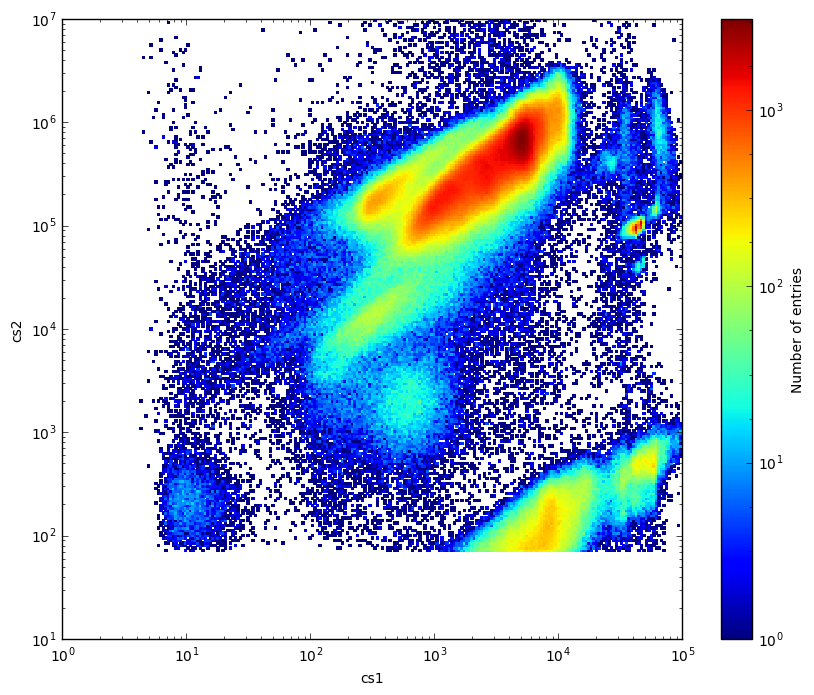

In [16]:
plt.figure(figsize=(10, 8))
mh.plot(log_scale=True)
plt.xscale('log')
plt.yscale('log')